In [ ]:
# download input_script.txt from drive
!gdown --id 1iP0K7yc0_FwBFIYqiJhyqRBgQO9-LEQt

Downloading...
From: https://drive.google.com/uc?id=1iP0K7yc0_FwBFIYqiJhyqRBgQO9-LEQt
To: /content/input_script.txt
100% 22.6k/22.6k [00:00<00:00, 33.0MB/s]


In [ ]:
import re
class ScriptProcessor:
    def __init__(self, filename):
        self.filename = filename

    def extract_dialogue(self, student_id = None, export = True):
        """
        Read file and extract dialogue lines from file
        Returns:
        1. list[tuple[character_name, dialogue]]: list of tuples of dialogue lines and the corresponding characters
        """
        
        # open the file
        with open(self.filename) as f:
            lines = f.readlines()
        
        # remove meta-data from start of script
        # First identify the last line of the header meta-data
        # i.e. get the indices of lines that starts with '[Scene'
        meta_idx = [idx for idx, line in enumerate(lines) if line.startswith('[Scene')]

        # The first index we get will be the last line of header meta-data
        header_last_idx = meta_idx[0]

        # Remove header meta-data
        lines = lines[header_last_idx + 1:]

        # Second, extract dialogue lines using the 'character: dialogue' pattern and the line that does not start with '['
        lines = [line for line in lines if len(line.split(':')) == 2 and not line.startswith('[')]

        # Lastly, extract the character and dialogue from the lines and remove meta-data within the dialogue
        dialogues = []
        for line in lines:
            character, dialogue = line.split(':')
            dialogue = re.sub(r'\(.*?\)', '', dialogue)
            dialogues.append((character,dialogue.strip()))

        if student_id and export:
            with open(student_id + '_clean_dialogue.txt', 'w') as f:
                f.write(str(dialogues))

        return dialogues

    def separate_dialogue(self, student_id):
        """
        Classify the dialogues based on characters spoken and export to their corresponding files
        Args:
        1. student_id(string): the student_id, which is used in file naming
        Returns:
        1. dict[string(character name): list[string(dialogue)]]: a dictionary with key as character name and value as a list of dialogues of that character
        """
        # First of all, obtain the character-dialogue pairs from extract_dialogue function
        dialogues = self.extract_dialogue(export = False)

        # Create an empty dictionary to store all the dialogues from different characters
        character_dialogue_dict = dict()

        for dialogue in dialogues:
            # for every character-dialogue pair, we get the lower-cased character name first
            # if the lower-cased character name does not exist as a key in the dictionary
            # we create a new key as the lower-cased character name and its value will be an empty list
            if dialogue[0].lower() not in character_dialogue_dict:
                character_dialogue_dict[dialogue[0].lower()] = []
            # then, we append the dialogue to the list with the key of the lower-cased character name
            character_dialogue_dict[dialogue[0].lower()].append(dialogue[1])
        
        # At last, we simply need to create output files for each character and dump the corresponding list to the file using '\n' as concatenater
        for character in character_dialogue_dict:
            with open(student_id + '_' + character + '.txt', 'w') as f:
                f.write('\n'.join(character_dialogue_dict[character]))

        # And return the dictionary
        return character_dialogue_dict

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
class ScriptAnalyser:
    def __init__(self, dialogue_dict):
        self.dialogue_dict = dialogue_dict

    def top_five_words(self, student_id = None, export = True):
        """
        Extract top 5 frequent words for characters who have spoken more than 100 unique words
        Args:
        1. student_id(str): the student_id used for export file naming
        2. export(bool): indicates whether export of DataFrame is required
        Returns:
        1. DataFrame: a DataFrame that records the top 5 frequent words for characters who have spoken more than 100 unique words
        """

        # check whether student_id is not None if export is True
        assert not (not student_id and export), 'student_id should be specified if export is True'
        
        # a list of tuple that stores the 'rows' of DataFrame
        top_five_tuples = []

        for character in self.dialogue_dict:
            unique_tokens = [] # a list that stores unique tokens for every dialogue
            
            for line in self.dialogue_dict[character]:
                # for every dialogue line, we lower-case all the characters and get unique tokens of the line
                # then, we extend the list of unique tokens to unique_tokens
                unique_tokens.extend(list(set([token.lower() for token in line.split()])))

            # the number of occurance of a word in unique_tokens list indicates the line frequency of each word
            # we simply need to use Counter to count the occurance of each word
            token_line_frequency = dict(Counter(unique_tokens))

            # next, we check whether the character has spoken more than 100 unique words using the length of the count dictionary
            if len(token_line_frequency) <= 100:
                continue

            # then, we sort the count dictionary using the values in descending order and extract the top 5 frequnent words
            top_five = sorted(token_line_frequency.items(),key=lambda x: x[1], reverse=True)[:5]

            # finally, we extend the information to top_five_tuples list
            top_five_tuples.extend(list(zip([character] * len(top_five), [i[0] for i in top_five],[i[1] for i in top_five])))

        # After we get all the rows from different characters, we can create a DataFrame
        df = pd.DataFrame(top_five_tuples,columns=['role','word','freq'])

        # If export is True, we need to export to csv file
        if export:
            df.to_csv(student_id + '_data.csv', index=False)
        return df

    def visualise(self):
        """
        Create a bar plot of the top 5 frequent words
        """

        # get data that we need to visualise
        top5 = self.top_five_words(export = False)

        # map character name with color and plot the bar plot
        colors = dict(zip(top5['role'].unique(), plt.get_cmap('Set1').colors))
        fig, ax = plt.subplots()
        top5.plot.bar(x='word',y='freq',color = [colors[i] for i in top5['role']], ax=ax)

        # set legend and other labels
        ax.legend(handles=[Line2D([0], [0], color=i[1], lw=4, label=i[0]) for i in colors.items()])
        ax.set_title('Count of top 5 words of each role')
        ax.set_ylabel('count')

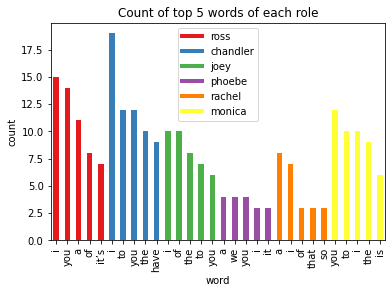

In [ ]:
sp = ScriptProcessor('input_script.txt')
sp.extract_dialogue('12345678')
dialogues = sp.separate_dialogue('12345678')


sa = ScriptAnalyser(dialogues)
sa.top_five_words('12345678')
sa.visualise()

### Justification and observations from the graph

The reason to choose colored bar chart is because it is easy to read and it can show multidimensional data in 2D plane. From the chart, we can observe that *i* is the most common top 5 words among the characters. However, it is interesting that Monica says *you* more than *i*.